In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
nav_data = pd.read_excel("千衍六和31号净值20250814.xlsx")
nav_data.sort_values(by=['日期'], inplace=True)
nav_data["nav_return"] = nav_data["复权净值"]/nav_data["复权净值"].shift(1) - 1
nav_data.rename(columns={'日期': 'date'}, inplace=True)
nav_data = nav_data[["date", "nav_return"]]
factor_return = pd.read_excel("factor_return.xlsx")
data = pd.merge(nav_data, factor_return, on='date', how='left')
data.dropna(inplace=True)

In [3]:
X = data.drop(columns=['date',"nav_return"])
y = data['nav_return']
model = sm.OLS(y, sm.add_constant(X)).fit()

### 风格暴露

In [5]:
coefficients = model.params.reset_index()
coefficients.rename(columns={"index":"factor", 0:"coefficient"}, inplace=True)

In [6]:
coefficients_barra = coefficients[33:]
coefficients_barra.sort_values(by='coefficient', ascending=False, inplace=True)
coefficients_industry = coefficients[2:33]
coefficients_industry.sort_values(by='coefficient', ascending=False, inplace=True)

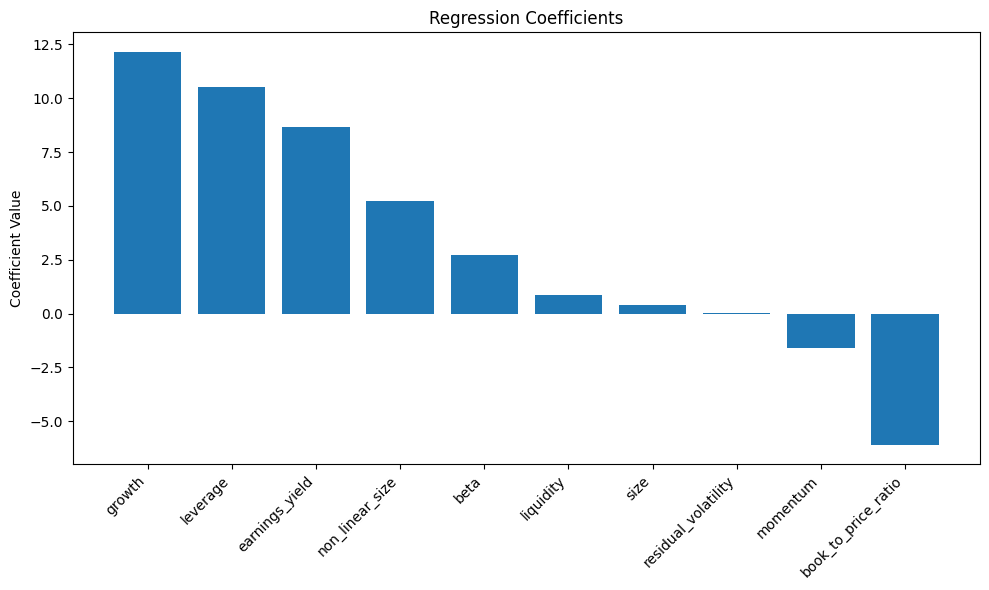

In [7]:
# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(coefficients_barra["factor"], coefficients_barra["coefficient"])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Coefficient Value')
plt.title('Regression Coefficients')
plt.tight_layout()
plt.show()

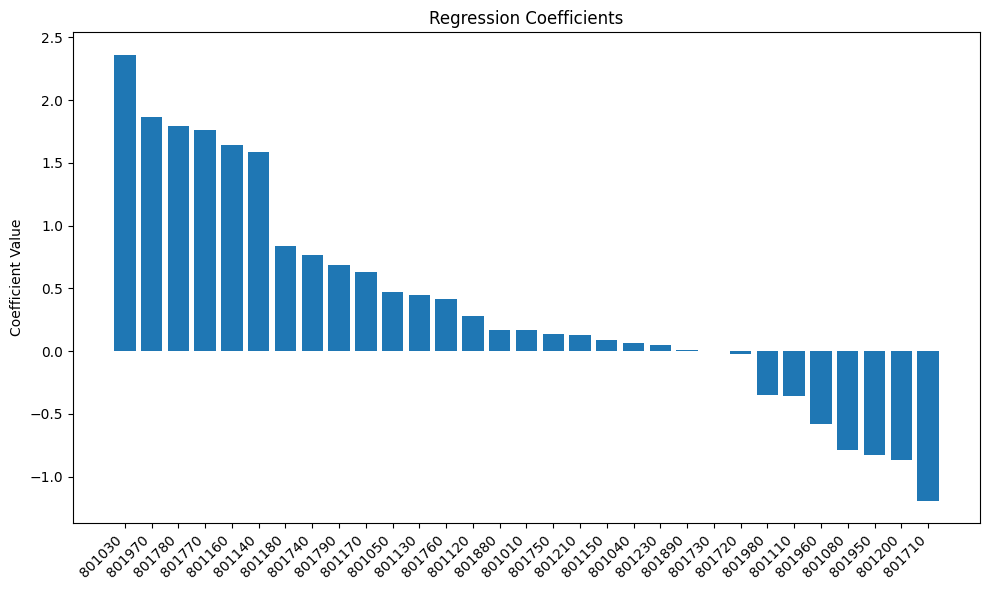

In [8]:
# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(coefficients_industry["factor"], coefficients_industry["coefficient"])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Coefficient Value')
plt.title('Regression Coefficients')
plt.tight_layout()
plt.show()

### 业绩归因(一次回归)

In [13]:
industry_beta = model.params[2:33]
barra_beta = model.params[33:]
barra_return = []
industry_return = []
for i in X.index:
    barra_return.append((barra_beta * X.loc[i, barra_beta.index]).sum())
    industry_return.append((industry_beta * X.loc[i, industry_beta.index]).sum())
data_return = data[["date","nav_return"]]
data_return["barra_return"] = barra_return
data_return["industry_return"] = industry_return
data_return.loc[1, ["barra_return","industry_return"]] = 0
data_return["nav_return_cumsum"] = (1 + data_return["nav_return"]).cumprod() - 1
data_return["barra_return_cumsum"] = (1 + data_return["barra_return"]).cumprod() - 1
data_return["industry_return_cumsum"] = (1 + data_return["industry_return"]).cumprod() - 1
data_return["residual_return_cumsum"] = data_return["nav_return_cumsum"] - data_return["barra_return_cumsum"] - data_return["industry_return_cumsum"]
data_return.set_index("date", inplace=True)

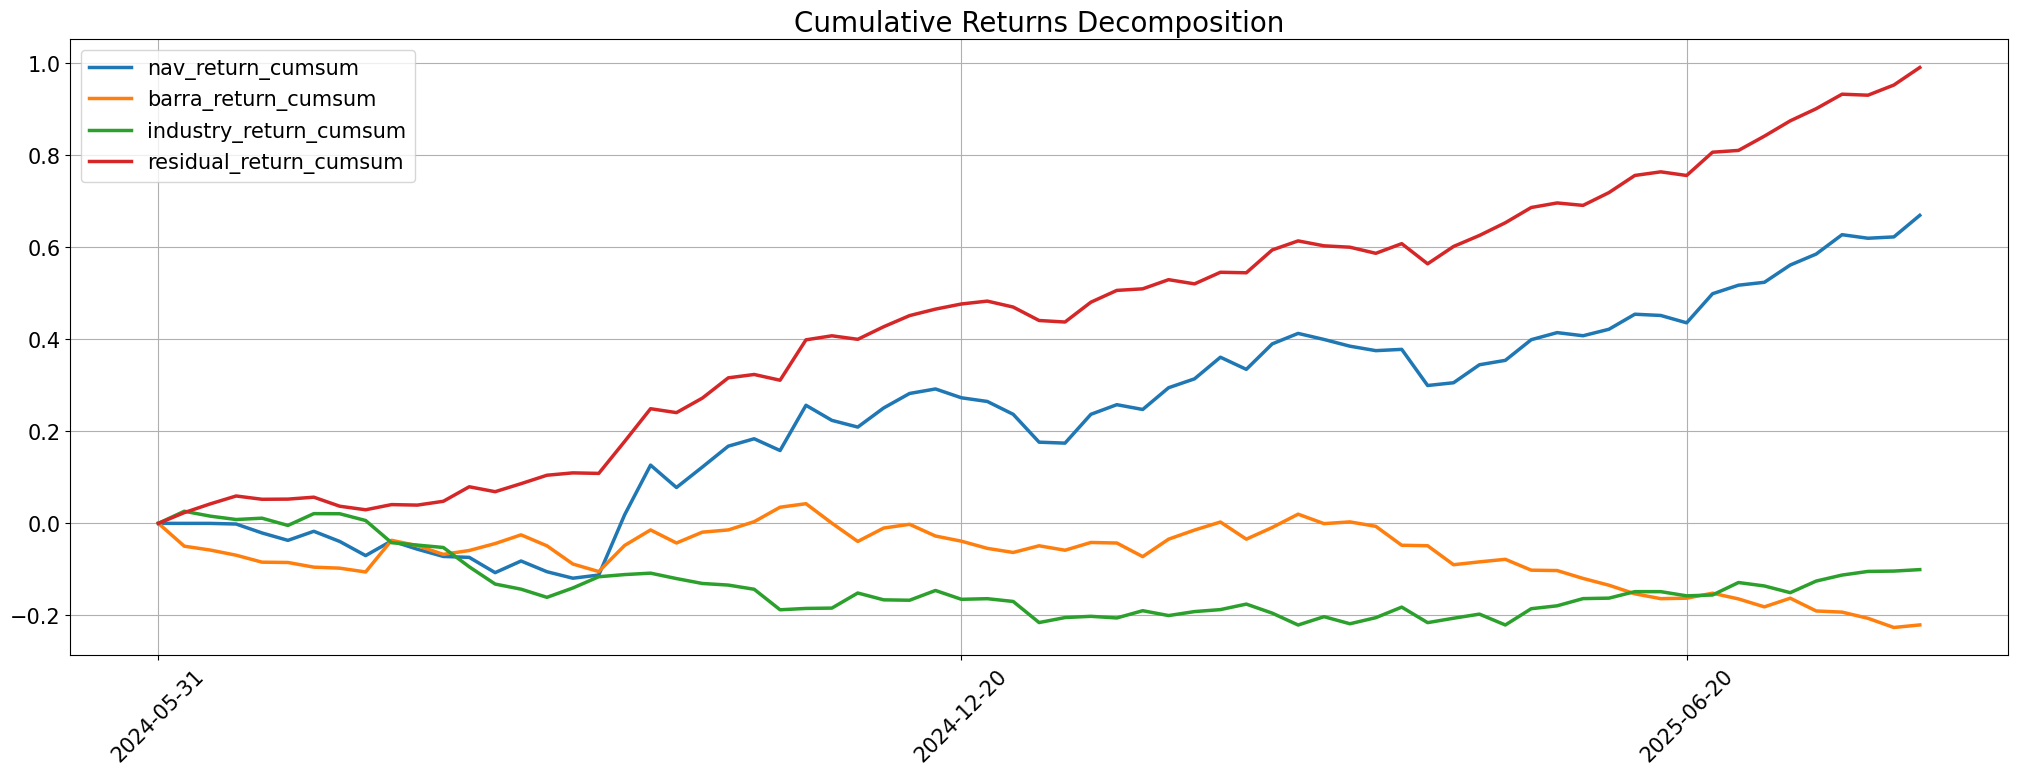

In [14]:
# 画Wind商品指数20日滚动年化波动率图
fig, (ax1) = plt.subplots(nrows=1, figsize=(25, 8))
ax1.plot(data_return["nav_return_cumsum"], label="nav_return_cumsum", linewidth=2.5)
ax1.plot(data_return["barra_return_cumsum"], label='barra_return_cumsum', linewidth=2.5)
ax1.plot(data_return["industry_return_cumsum"], label='industry_return_cumsum', linewidth=2.5)
ax1.plot(data_return["residual_return_cumsum"], label='residual_return_cumsum', linewidth=2.5)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.tick_params(axis="x", rotation=45, labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax1.set_title("Cumulative Returns Decomposition", size=20)
ax1.legend(loc="upper left", fontsize=15)
ax1.grid()

### 业绩归因（滚动回归）

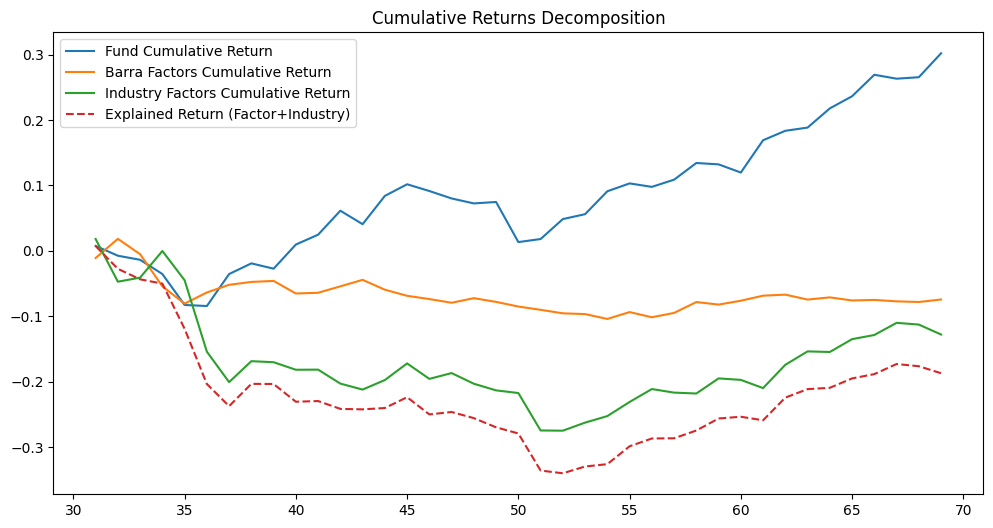

In [ ]:
# 假设数据已准备：y是因变量(基金收益)，X是自变量(包含因子和行业)
window = 30
factor_contributions = []
industry_contributions = []
residual_contributions = []

# 创建结果DataFrame
results = pd.DataFrame(index=y.index[window:])

for t in range(window, len(data)):
    # 滚动窗口数据
    y_rolling = y.iloc[t-window:t]
    X_rolling = X.iloc[t-window:t]
    
    # 拟合模型
    model = sm.OLS(y_rolling, sm.add_constant(X_rolling)).fit()
    
    # 获取当前期的因子暴露
    current_X = X.iloc[t-1]  # 使用t-1因为X.index可能与y对齐
    
    # 计算各类贡献
    barra_beta = model.params[33:]  # 假设33之后是barra因子
    barra_return = (barra_beta * current_X[barra_beta.index]).sum()
    
    beta_industry = model.params[2:33]  # 假设2-33是行业因子
    industry_return = (beta_industry * current_X[beta_industry.index]).sum()
    
    # 残差项(alpha)
    residual = model.params[0]  # 常数项作为alpha
    
    # 存储结果
    factor_contributions.append(barra_return)
    industry_contributions.append(industry_return)
    residual_contributions.append(residual)

# 转换为Series
results['barra_return'] = factor_contributions
results['industry_return'] = industry_contributions
results['residual_return'] = residual_contributions
results['nav_return'] = y[window:]  # 实际基金收益

# 累计收益计算
results['nav_return_cumsum'] = (1 + results['nav_return']).cumprod() - 1
results['barra_return_cumsum'] = (1 + results['barra_return']).cumprod() - 1
results['industry_return_cumsum'] = (1 + results['industry_return']).cumprod() - 1
results['residual_return_cumsum'] = (1 + results['residual_return']).cumprod() - 1

# 也可以计算组合累计收益(因子+行业)
results['explained_return_cumsum'] = (1 + results['barra_return'] + results['industry_return']).cumprod() - 1

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['nav_return_cumsum'], label='Fund Cumulative Return')
plt.plot(results.index, results['barra_return_cumsum'], label='Barra Factors Cumulative Return')
plt.plot(results.index, results['industry_return_cumsum'], label='Industry Factors Cumulative Return')
plt.plot(results.index, results['explained_return_cumsum'], label='Explained Return (Factor+Industry)', linestyle='--')
plt.legend()
plt.title('Cumulative Returns Decomposition')
plt.show()